In [82]:
# import libraries
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
from keras.src.models import Sequential
from keras import  optimizers
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import seaborn as sns
sns.set(color_codes=True)
from keras.layers import Input, Dense, GaussianNoise, Dropout
from keras.models import Model
from keras import regularizers
from tensorflow import keras

In [83]:
# Load datasets
train = pd.read_csv(r"./Dataset/outsmarting-outbreaks-challenge20241207-28044-iehqcg (1)/Train.csv")
test = pd.read_csv(r"./Dataset/outsmarting-outbreaks-challenge20241207-28044-iehqcg (1)/Test.csv")
toilets = pd.read_csv(r"./Dataset/outsmarting-outbreaks-challenge20241207-28044-iehqcg (1)/toilets.csv")
waste_management = pd.read_csv(r"./Dataset/outsmarting-outbreaks-challenge20241207-28044-iehqcg (1)/waste_management.csv")
water_sources = pd.read_csv(r"./Dataset/outsmarting-outbreaks-challenge20241207-28044-iehqcg (1)/water_sources.csv")


# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

In [84]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Year', 'Month'], inplace=True)

# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:

            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)
            #print(f"{prefix}_{col}")

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")

# Fill missing values in the 'Total' column
hospital_data['Total'].fillna(0, inplace=True)

# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

C:\Users\ANISH\AppData\Local\Temp\ipykernel_5156\101803625.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hospital_data['Total'].fillna(0, inplace=True)


In [85]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest

# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [86]:
# Merge datasets with nearest locations
merged_data = hospital_data.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

file_path = 'Data.csv'
merged_data.to_csv(file_path, index=False)



In [87]:
# Understanding Data
df = merged_data
df.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,...,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589


In [88]:
df.describe()

,Total,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,...,water_ssrd,water_strd,water_e,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude
count,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,...,2.933200e+04,2.933200e+04,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000
mean,6.944429,6.555809,2021.012069,-8.612038,68.241678,-0.850759,0.078674,291.691981,296.328951,-0.001802,...,1.694240e+07,2.997320e+07,-0.002682,0.003050,0.252395,0.264809,0.265012,0.300412,-8.612131,68.240968
std,25.678473,3.446893,1.367514,0.041987,0.028852,0.459508,0.670945,2.264581,1.684654,0.000562,...,3.617301e+06,6.834658e+06,0.000947,0.002715,0.101568,0.084671,0.056588,0.043562,0.042424,0.027849
min,0.000000,1.000000,2019.000000,-8.713760,68.169720,-1.741580,-0.866400,286.339000,292.505000,-0.002696,...,9.782430e+06,1.767190e+07,-0.004622,0.000326,0.118027,0.150421,0.202789,0.201157,-8.714190,68.175160
25%,0.000000,4.000000,2020.000000,-8.626310,68.224400,-1.364380,-0.655191,290.366000,294.726000,-0.002391,...,1.344400e+07,1.873770e+07,-0.003365,0.000799,0.151459,0.187378,0.215134,0.255463,-8.626990,68.224550
50%,0.000000,7.000000,2021.000000,-8.617350,68.237620,-0.844635,0.423794,292.571000,296.089000,-0.001784,...,1.752270e+07,3.329590e+07,-0.002558,0.002266,0.234497,0.276703,0.247650,0.307953,-8.617370,68.238980
75%,1.000000,10.000000,2022.000000,-8.594310,68.254900,-0.416975,0.581028,293.429000,297.876000,-0.001374,...,1.968420e+07,3.525000e+07,-0.002150,0.005312,0.348724,0.332657,0.300964,0.330185,-8.594920,68.254900
max,489.000000,12.000000,2023.000000,-8.496810,68.328390,-0.268989,1.184410,294.638000,298.937000,-0.000637,...,2.238040e+07,3.611100e+07,-0.000897,0.010761,0.408691,0.410736,0.420380,0.422104,-8.500850,68.329130


In [89]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
   # print("##################### Head #####################")
   # print(dataframe.head(3))
   # print("##################### Tail #####################")
   # print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    
    
check_df(df)

##################### Shape #####################
(29332, 135)
##################### Types #####################
ID                                object
Total                            float64
Location                          object
Category_Health_Facility_UUID     object
Disease                           object
                                  ...   
water_Transformed_Latitude       float64
water_Transformed_Longitude      float64
water_Month_Year                  object
lat_lon                           object
Month_Year_lat_lon                object
Length: 135, dtype: object
##################### NA #####################
ID                               0
Total                            0
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
                                ..
water_Transformed_Latitude       0
water_Transformed_Longitude      0
water_Month_Year                 0
lat_lon                          0
Month_Year_l

In [90]:
categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
numerical_cols = [ i for i in df.columns if i not in categorical_cols]
print("Categorical Column:", categorical_cols)
print("\nNumerical Column:", numerical_cols)

Categorical Column: ['ID', 'Location', 'Category_Health_Facility_UUID', 'Disease', 'toilet_Month_Year_lat_lon', 'toilet_Month_Year', 'lat_lon_x', 'Month_Year_lat_lon_x', 'waste_Month_Year_lat_lon', 'waste_Month_Year', 'lat_lon_y', 'Month_Year_lat_lon_y', 'water_Month_Year_lat_lon', 'water_Month_Year', 'lat_lon', 'Month_Year_lat_lon']

Numerical Column: ['Total', 'Month', 'Year', 'Transformed_Latitude', 'Transformed_Longitude', 'toilet_10u', 'toilet_10v', 'toilet_2d', 'toilet_2t', 'toilet_evabs', 'toilet_evaow', 'toilet_evatc', 'toilet_evavt', 'toilet_albedo', 'toilet_lshf', 'toilet_lai_hv', 'toilet_lai_lv', 'toilet_pev', 'toilet_ro', 'toilet_src', 'toilet_skt', 'toilet_es', 'toilet_stl1', 'toilet_stl2', 'toilet_stl3', 'toilet_stl4', 'toilet_ssro', 'toilet_slhf', 'toilet_ssr', 'toilet_str', 'toilet_sp', 'toilet_sro', 'toilet_sshf', 'toilet_ssrd', 'toilet_strd', 'toilet_e', 'toilet_tp', 'toilet_swvl1', 'toilet_swvl2', 'toilet_swvl3', 'toilet_swvl4', 'toilet_Transformed_Latitude', 'toilet

In [91]:
# categorical data
df_train = df[df['Year'] < 2023]

for i,col in enumerate(categorical_cols):
    print(col, 'unique words example :', df[col].unique()[0:7], "\n Noof unique words:",len( df[col].unique()),'\n----------------------------------------------------------')


ID unique words example : ['ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Dysentery'
 'ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Typhoid'
 'ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Diarrhea'
 'ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Schistosomiasis'
 'ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Malaria'
 'ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Intestinal Worms'
 'ID_3a11929e-3317-476d-99f7-1bd9fb58f018_11_2022_Dysentery'] 
 Noof unique words: 17873 
----------------------------------------------------------
Location unique words example : ['ID_3a11929e-3317-476d-99f7-1bd9fb58f018'
 'ID_90ae3848-6fe9-4326-95ee-d7b8679e7494'
 'ID_bd1b57a9-066c-497a-bdef-7ae8e849db14'
 'ID_a81e0fdf-34f9-4334-b25d-20194fad0381'
 'ID_6f399bd7-f181-432a-bddc-9fff8dca7f81'
 'ID_704a38c1-35ca-4e81-ab81-02fcf41d1f72'
 'ID_8c25ad79-9b7f-4ba0-8e03-69cbfcd39569'] 
 Noof unique words: 58 
----------------------------------------------------------
Category_Health_Facility_UUID uni

In [92]:
# categorical data
# for i,col in enumerate(numerical_cols):
#     print(col, ':', df[col].unique()[0:6], "Noof unique vaalues:",len( df_train[col].unique()),'\n----------------------------------------------------------')


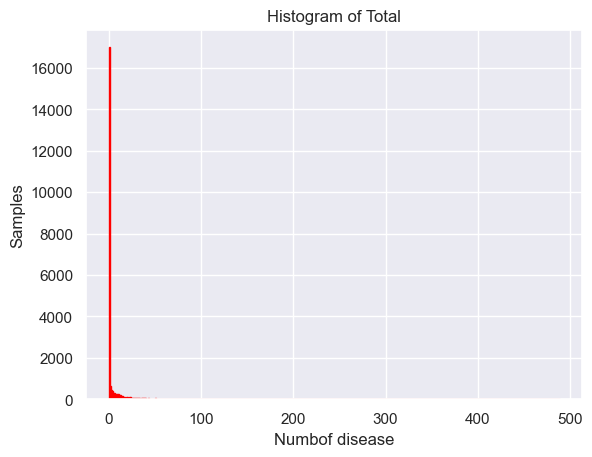

In [93]:
# Visualize Data
# label plot
label_name = 'Total'
num_buckets = 500
plt.hist(df_train[label_name], bins=num_buckets, edgecolor='red')
plt.xlabel(f'Numbof disease')
plt.ylabel('Samples')
plt.title(f'Histogram of {label_name}')
plt.show()

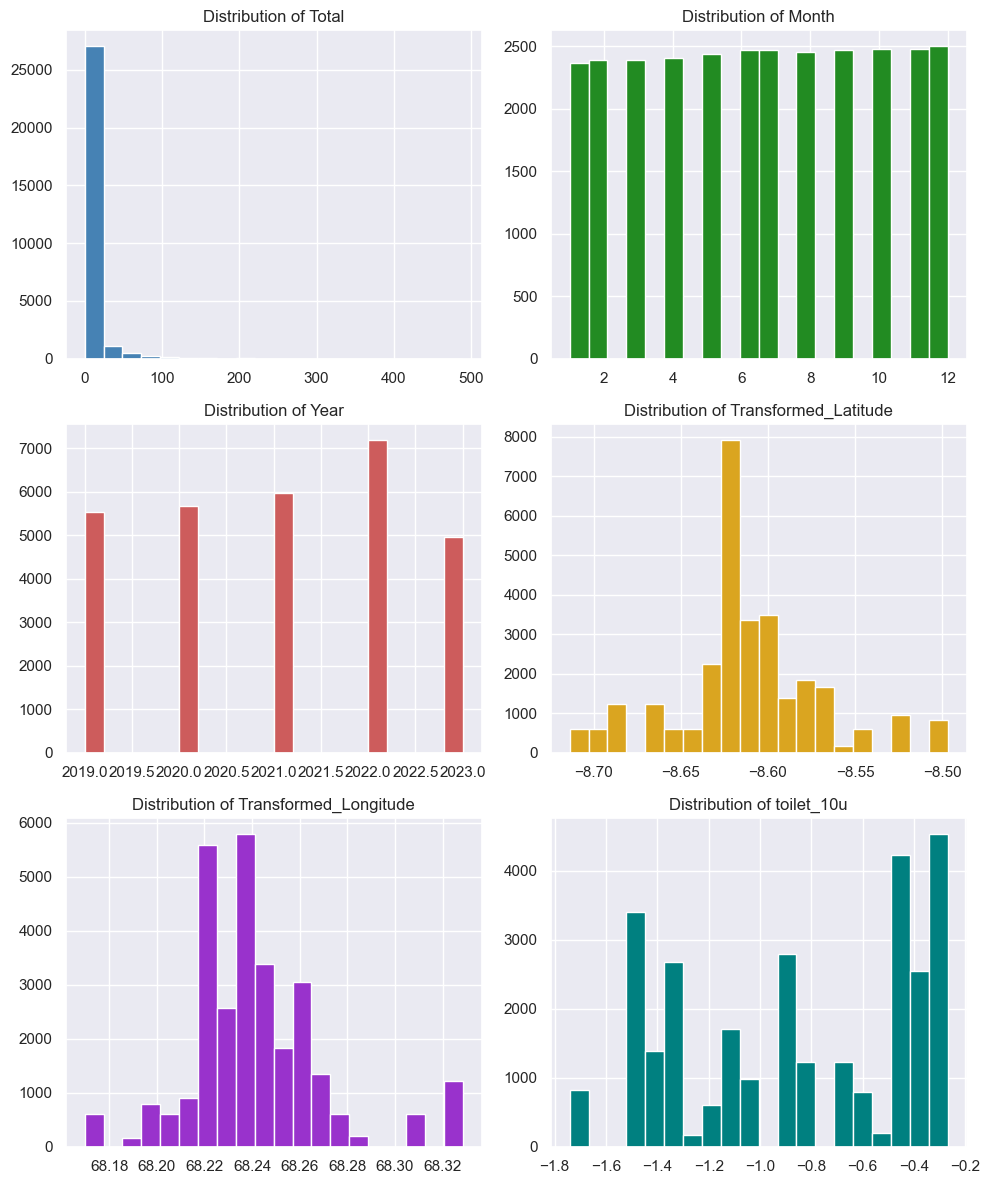

In [94]:
#Now let's understand the numerical columns:

num_cols = numerical_cols[0:6]
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

colors = ['steelblue', 'forestgreen', 'indianred', 'goldenrod', 'darkorchid', 'teal', 'lightblue', 'olive','crimson', 'deepskyblue', 'mediumseagreen', 'darkorange', 'slateblue',
    'darkmagenta', 'lightcoral', 'dodgerblue', 'limegreen', 'orangered',
    'plum', 'mediumpurple', 'khaki', 'cornflowerblue', 'sienna',
    'chocolate', 'turquoise', 'orchid', 'peru', 'mediumvioletred',
    'tomato', 'seagreen', 'palevioletred', 'cadetblue', 'mediumorchid',
    'darkgoldenrod', 'firebrick', 'peachpuff', 'lightseagreen', 'tan',
    'slategrey', 'lavender', 'powderblue', 'mediumturquoise', 'salmon',
    'darkslateblue', 'coral', 'darkolivegreen', 'lightpink', 'royalblue',
    'darkcyan', 'palegreen', 'lightsteelblue', 'mediumspringgreen', 'bisque',
    'rosybrown', 'navajowhite', 'aquamarine', 'violet', 'gold']
for i, col in enumerate(num_cols):
    row = i // 2
    col_idx = i % 2
    axes[row, col_idx].hist(df[col], bins=20, color=colors[i])
    axes[row, col_idx].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [95]:
# process data
merged_data = merged_data.fillna(0)
merged_data = merged_data.drop_duplicates()  ################### drop duplicate
merged_data = merged_data.drop_duplicates(subset=['ID', 'Disease'], keep='first')

merged_data['Date'] = pd.to_datetime(merged_data[['Year', 'Month']].assign(DAY=1))
merged_data = merged_data.sort_values(by='Date')
merged_data = merged_data.drop(columns='Date')
test_id = merged_data[merged_data['Year'] >= 2023]['ID']
target_= merged_data[merged_data['Year'] < 2023]
y = target_['Total'].values.astype('float32')

merged_data['Category_Health_Facility_UUID'] = merged_data['Category_Health_Facility_UUID'].apply(lambda x: '-'.join(x.split('-')[:-1]))
merged_data = merged_data.drop(columns=['Total','ID', 'Location',  'toilet_Month_Year_lat_lon', 'toilet_Month_Year', 'lat_lon_x','Month_Year_lat_lon_x', 'waste_Month_Year_lat_lon', 'waste_Month_Year','lat_lon_y', 'Month_Year_lat_lon_y', 'water_Month_Year_lat_lon', 'water_Month_Year', 'lat_lon', 'Month_Year_lat_lon'], axis=1)
for col in ['Category_Health_Facility_UUID', 'Disease']:
    merged_data = pd.get_dummies(merged_data, columns=[col])

merged_data = merged_data.replace({True: 1, False: 0})

C:\Users\ANISH\AppData\Local\Temp\ipykernel_5156\2854359769.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data = merged_data.replace({True: 1, False: 0})


In [96]:
# standard normalize
mean = merged_data.mean(axis=0)
std  = merged_data.std(axis=0)

# split train test
train_datas = merged_data[merged_data['Year'] < 2023]
test_df = merged_data[merged_data['Year'] >= 2023]

train_datas -= mean
train_datas /= std
test_df -= mean
test_df /= std

In [97]:
#Split data into training and validation sets
X = np.array(train_datas)
num_samples = len(X)
train_size = int(0.95 * num_samples)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [98]:
def get_model(input_dim, num_units, act, dp=0.1, gauss_std=0.3, num_hidden_layers=1, num_quantiles=2):
    input = Input((input_dim,), name='input')
    from tensorflow.keras.initializers import Constant
    initialize = 'he_normal'
    x = input
    from tensorflow.keras.initializers import Constant
    for i in range(num_hidden_layers):
        x = Dense(num_units[i], use_bias=True, kernel_initializer=initialize, bias_initializer=initialize,
                  kernel_regularizer=regularizers.l2(0.01), activation=act[i])(x)
        x = Dropout(dp[i])(x)
        x = GaussianNoise(gauss_std[i])(x)

    x = Dense(num_quantiles, activation=None, use_bias=True, kernel_initializer=initialize,
              bias_initializer=initialize)(x)

    model = Model(input, x)
    return model

In [99]:
# Parameters
input_dim = X.shape[1]
num_hidden_layers = 3
num_units = [ 300, 200, 100, 50]#[300,200, 100,50,10]
act = ['relu','relu', 'relu', 'relu','relu']#['elu','elu', 'elu', 'elu','elu'] #['relu','relu', 'relu', 'relu','relu']
dropout = [0.5,0.5, 0.5,0.5,0.5]
gauss_std = [0.1,0.1,0.2,0.2,0.2]
num_quantiles = 1
EPOCHS = 100
VERBOSE = 0

In [100]:
model = get_model(input_dim, num_units, act, dropout, gauss_std, num_hidden_layers, num_quantiles)
model.summary()

model.compile(loss='mae',
              optimizer=optimizers.RMSprop(learning_rate=0.0001))

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 129)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 300)                 │          39,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_12 (GaussianNoise)    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 200)                 │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_13 (GaussianNoise)    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_14 (GaussianNoise)    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,401 (466.41 KB)

 Trainable params: 119,401 (466.41 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# train model

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(x=X_train, y=y_train,
          epochs=EPOCHS,
          validation_split=0.2,
          batch_size=64,
            callbacks=[early_stop, lr_schedule] ,
                   verbose= VERBOSE,
          shuffle=True,
         )

In [102]:
# Predict using the validation set
predictions = model.predict(X_val)
predictions = np.array(predictions).astype('int32')
print("Mean Absolute Error:", mean_absolute_error(y_val, predictions))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean Absolute Error: 5.311828136444092


In [103]:

testX = np.reshape(test_df,(test_df.shape[0], test_df.shape[1],1))
testX = test_df
y_pred = model.predict(np.array(testX))

y_pred = np.array(y_pred).astype('int32')
for i in range(len(y_pred)):
    if y_pred[i] <=0:
        y_pred[i] = 0

y_pred = np.concatenate((np.expand_dims(test_id, axis=1),y_pred), axis=1)
tested = pd.DataFrame(y_pred)
tested.to_csv('Submission.csv', header=['ID','target'], index=False)


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
